In [29]:
from pandas import read_csv
import pandas as pd
from datetime import datetime
import missingno as msno

from math import sqrt
import numpy as np
from numpy.random import randn
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
import random
import time

dataframe = pd.read_csv("/kaggle/input/wind-power-forecasting/Turbine_Data.csv")

<AxesSubplot:>

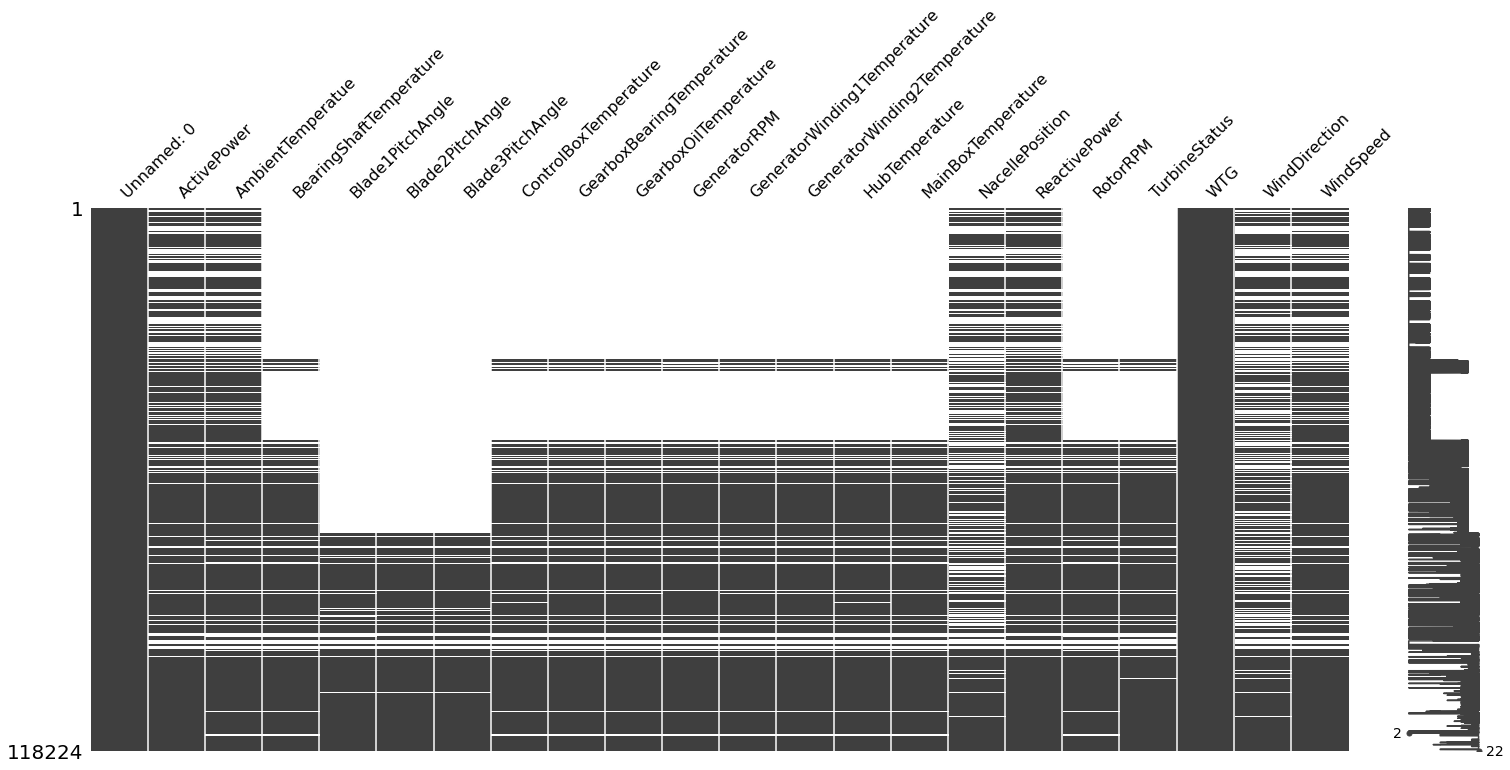

In [30]:
msno.matrix(dataframe) #plots the missing numbers 

In [66]:
np.unique(np.array(dataframe['ControlBoxTemperature']))

array([ 0., nan])

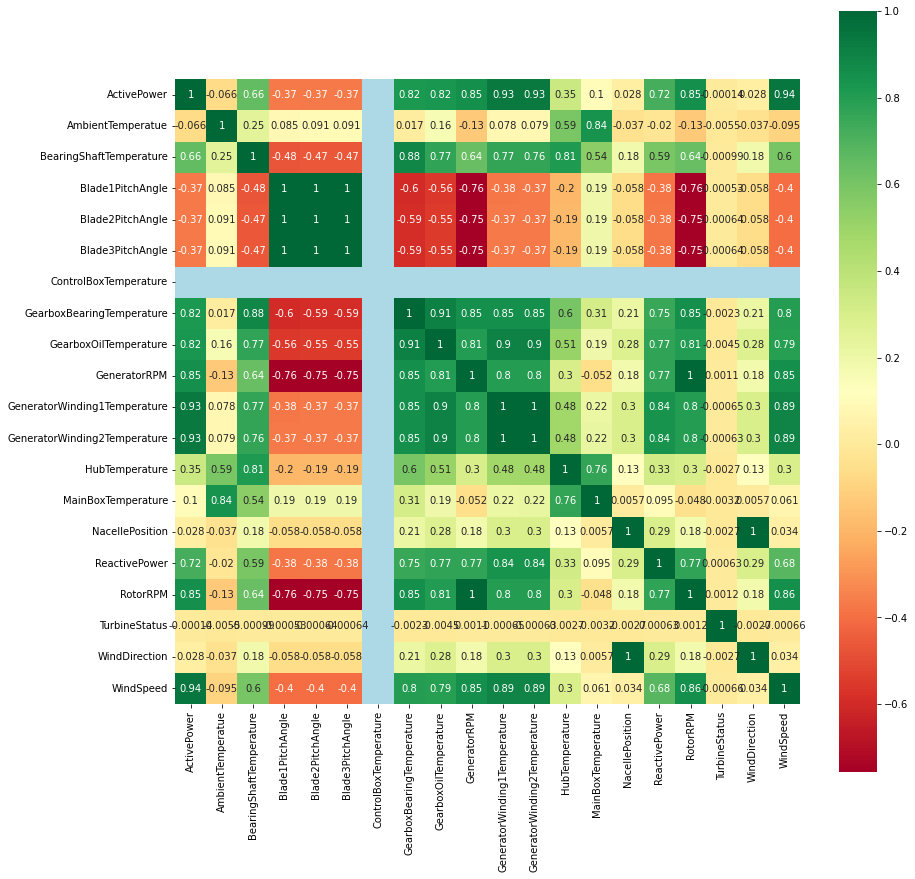

In [64]:
#This further simplifies our task.
import matplotlib as mpl
plt.subplots(figsize=(14, 14))
cmap = mpl.cm.get_cmap("RdYlGn").copy()
#color.set_bad('lightblue') 
sns.heatmap(dataframe.corr(), annot=True, square=True, cmap = cmap)
# plt.savefig('23_09_5.png')
plt.show()

In [ ]:
idxs = []

# we first get rid of all features that have no correlation with the active power
for i, corr in enumerate(dataframe.corr()['ActivePower']):
    if corr > 0 and pd.notna(corr):
        idxs.append(i)
        
idxs = idxs[1:]
selected_features = dataframe.corr()['ActivePower'][idxs]

# eliminate some features that are redundant, i.e. they have high correlation 
# and they physically correspond to a similar event (gearbox bearing T and gearbox oil T)
selected_features = selected_features.drop(labels=['GearboxOilTemperature', 'GeneratorWinding1Temperature', 'RotorRPM', 'NacellePosition'])
selected_features = selected_features.drop(labels=['WindDirection'])
sel_feature_names = [idx for idx, val in selected_features.iteritems()]
#adding ActivePower
sel_feature_names.insert(0, 'ActivePower')
reduced_df = dataframe[sel_feature_names]
print(f"The selected features are:\n{sel_feature_names}")

In [65]:
dataframe.corr()['ActivePower']['ControlBoxTemperature']

nan

In [33]:
idxs

[2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]

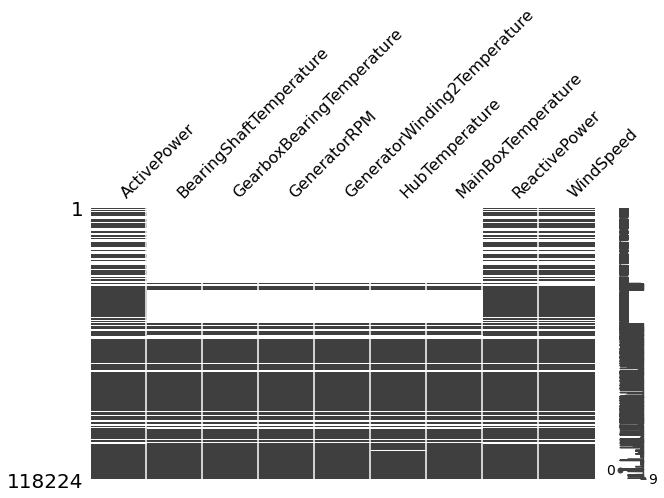

In [34]:
msno.matrix(reduced_df, figsize=(10,5))
# fig.savefig('reduced_df_missingvalues.png')
plt.show()

In [35]:
#pre-processing

#generate timestamp for the observations mimicking the "unnamed:0" feature
rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
time_df = pd.DataFrame(rng)

#fill in missing values with zero using the fillforward function
reduced_df = reduced_df.fillna(0).astype(float)
#concatenate both the timestamp range and filled in features
reduced_df = pd.concat((time_df, reduced_df), axis=1)
#set up index
reduced_df = reduced_df.set_index(0)

#select a subset of data period from second half of original dataset, to ensure we have better quality signal (see completness comment of msno matrix plot above in the code)
reduced_df = reduced_df.loc['2019-12-17':]

In [36]:
def forecast_accuracy(forecast, actual):
    '''
    Returns evaluation metrics given predicted and true values.
    '''
    forecast = np.array(forecast)
    actual = np.array(actual)
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    return({'mae': mae, 
            'rmse':rmse, 
            'corr':corr})

# scales back from normalized values
def invert_values(y_pred, y_test, scaler):
    '''
    De-normalizes the predicted and true values given a scaler. 
    '''
    n_ahead = 144
    rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
    time_df = pd.DataFrame(rng)
    
    # Creating the predictions date range
    days = time_df.values[-len(y_pred):-len(y_pred) + n_ahead]
    days_df = pd.DataFrame(days)
    
    pred_n_ahead = pd.DataFrame(y_pred)
    actual_n_ahead = pd.DataFrame(y_test)
    
    #repeat the column series n times (being n the number of features used), to make shape compatible for scale inversion
    pr_p = pd.concat([pred_n_ahead]*len(sel_feature_names), axis=1)
    ac_p = pd.concat([actual_n_ahead]*len(sel_feature_names), axis=1)

    #inverse scale tranform the series back to kiloWatts of power
    pred_power = scaler.inverse_transform(pr_p)[:,0]
    actual_power = scaler.inverse_transform(ac_p)[:,0]
    
    return pred_power, actual_power



def plot_random_predictions(pred_power, actual_power, n_predictions = 4):
    '''
    Plots the prediction of 6 randomly selected days (out of the 21 predicted).
    The zeros that are filled in during pre-processing are marked in lime green
    '''
    if n_predictions > 21:
        print('Error: there are only 21 days in the predicted set')
        return
    
    # for all 21 days in total
    days = np.arange(0,21)
    np.random.shuffle(days)

    # we assume hard zeros are the ones forced by pre-processing
    cond_color = np.where(actual_power==0, 'lime', plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

    fig, ax = plt.subplots(2,2, figsize=(30, 20))

    ax_h = 0
    ax_v = 0
    for i in range(0,n_predictions):
        ax[ax_h,ax_v].plot(rng[days[i]*144:(days[i]+1)*144], actual_power[days[i]*144:(days[i]+1)*144], label="actual")
        ax[ax_h,ax_v].scatter(rng[days[i]*144:(days[i]+1)*144], actual_power[days[i]*144:(days[i]+1)*144], color=cond_color[days[i]*144:(days[i]+1)*144])
        ax[ax_h,ax_v].plot(rng[days[i]*144:(days[i]+1)*144], pred_power[days[i]*144:(days[i]+1)*144], marker='o', label="prediction")
        ax[ax_h,ax_v].legend()
        ax[ax_h,ax_v].set_title(f"Predicted vs. Actual Power (Day {days[i]+1})")
        ax[ax_h,ax_v].set_xlabel("Time")
        ax[ax_h,ax_v].set_ylabel("Power (kW)")
        if i%2 == 0:
            ax_v = 1
        else:
            ax_h += 1
            ax_v = 0
    plt.savefig('random_predictions_actual.png')
    plt.show()

In [37]:
scaler = MinMaxScaler()
scaler.fit(reduced_df.values)
data_scaled = scaler.transform(reduced_df.values)
print(data_scaled)

[[0.16057759 0.69345275 0.78378305 ... 0.63190319 0.45724593 0.48070408]
 [0.16127537 0.69341519 0.78262095 ... 0.63092155 0.45685814 0.48477793]
 [0.1548251  0.69292728 0.78199566 ... 0.62985529 0.45286892 0.48513059]
 ...
 [0.03353111 0.82766998 0.77120125 ... 0.7044766  0.37472375 0.32226445]
 [0.05689067 0.82551774 0.7681129  ... 0.70205622 0.38855814 0.31768264]
 [0.06060743 0.82347474 0.77307882 ... 0.70022848 0.39293048 0.33613123]]


In [38]:
# we split the data for train, validation and further test

test_split_days = 21
val_split_days = 10

test_split_idx = len(reduced_df) - 144 * test_split_days
val_split_idx = test_split_idx - 144 * val_split_days

train_data = data_scaled[:test_split_idx]
test_data = data_scaled[test_split_idx:]
print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}\n")

Train data shape: (12096, 9)
Test data shape: (3024, 9)



In [39]:
# seperate the predictor variables and regressor variable

x_train, y_train = train_data[:,1:], train_data[:,0]
print(f"Train values shape: {x_train.shape}\nTrain labels shape: {y_train.shape}")

x_test, y_test = test_data[:,1:], test_data[:,0]
print(f"Test values shape: {x_test.shape}\nTest labels shape: {y_test.shape}\n")

Train values shape: (12096, 8)
Train labels shape: (12096,)
Test values shape: (3024, 8)
Test labels shape: (3024,)



In [47]:
cv_params = {'epsilon': np.linspace(0,1,100),'C': np.linspace(1,10,10)}

grid = GridSearchCV(SVR(), cv_params, scoring='neg_mean_absolute_error', cv=21, n_jobs=4, verbose=1)
grid.fit(x_train, y_train)
print(f"The best model has parameters C={grid.best_params_['C']} and epsilon={grid.best_params_['epsilon']}")

# predict using the best model
#y_pred_svr = grid.best_estimator_.predict(x_test);

Fitting 21 folds for each of 1000 candidates, totalling 21000 fits
The best model has parameters C=10.0 and epsilon=0.0


In [48]:
svr_model = SVR(epsilon=0.0, C=1.0)
svr_model.fit(x_train, y_train)

#predict
y_pred_svr = svr_model.predict(x_test)

# de-normalize values
pred_power_svr, actual_power_svr = invert_values(y_pred_svr, y_test, scaler)

# get scores
forecast_accuracy(pred_power_svr, actual_power_svr)

{'mae': 21.186869441120898,
 'rmse': 59.04792384754308,
 'corr': 0.9946779259444696}

In [57]:
svr_model = SVR(epsilon=0.01, C=0.99)
svr_model.fit(x_train, y_train)

#predict
y_pred_svr = svr_model.predict(x_test)

# de-normalize values
pred_power_svr, actual_power_svr = invert_values(y_pred_svr, y_test, scaler)

# get scores
forecast_accuracy(pred_power_svr, actual_power_svr)

{'mae': 22.53449196860692,
 'rmse': 49.34333057801442,
 'corr': 0.9964822296509501}

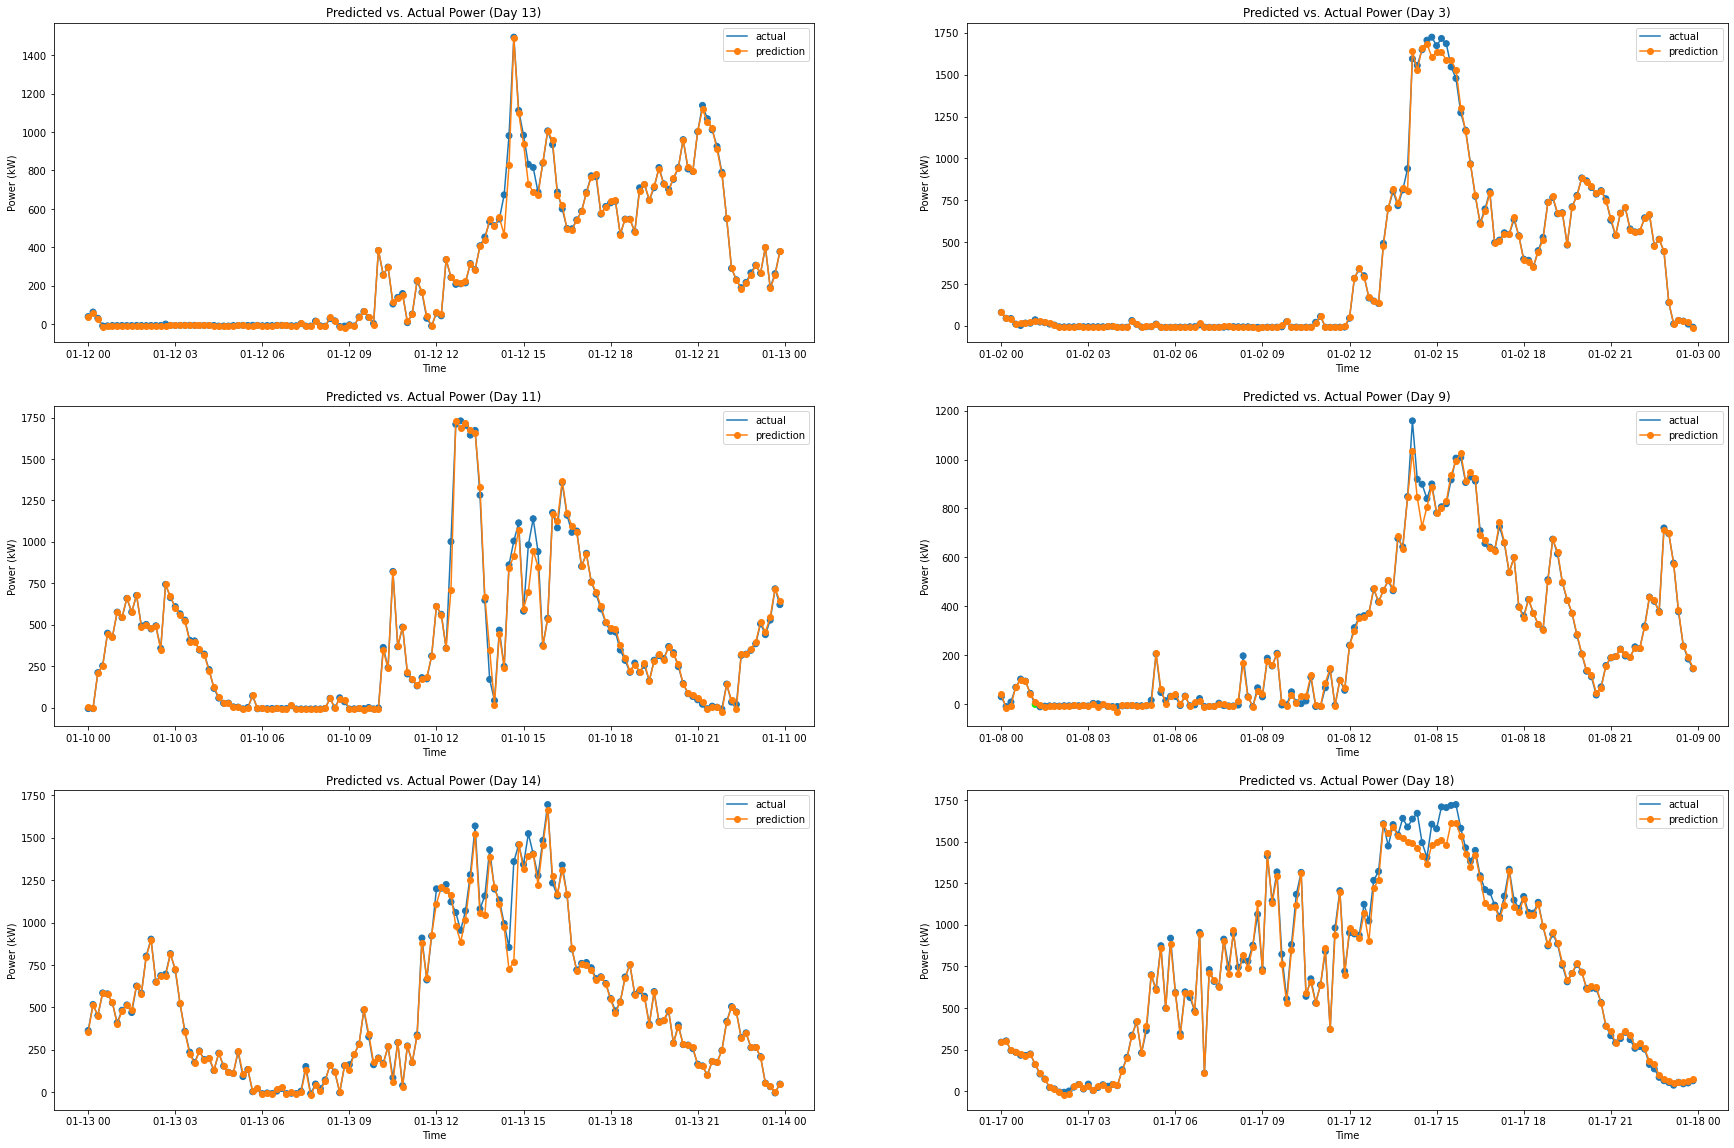

In [49]:
plot_random_predictions(pred_power_svr, actual_power_svr)

In [50]:
residuals_svr = pd.Series(pred_power_svr-actual_power_svr)
residuals_svr.describe()

count    3024.000000
mean      -12.042642
std        57.816412
min      -689.667384
25%        -8.435141
50%        -0.385166
75%         3.731526
max       530.220875
dtype: float64

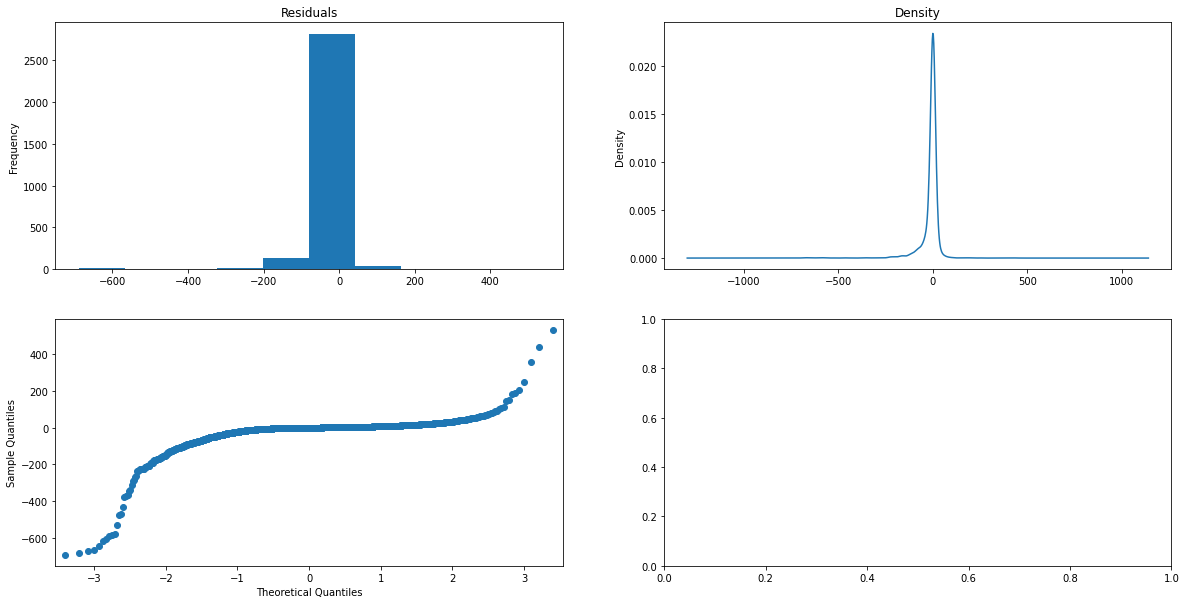

In [58]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
residuals_svr.plot(kind='hist', title="Residuals", ax=ax[0,0])
residuals_svr.plot(kind='kde', title='Density', ax=ax[0,1])
qqplot(residuals_svr, ax=ax[1,0])
# autocorrelation_plot(residuals_svr, ax=ax[1,1])
plt.savefig('residuals_.png')
plt.show()